In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

In [2]:
df = pd.read_csv(os.getcwd() + '/Data/btc.csv')
df.shape

(4568, 140)

In [3]:
df.tail()

,date,AdrActCnt,AdrBal1in100KCnt,AdrBal1in100MCnt,AdrBal1in10BCnt,AdrBal1in10KCnt,AdrBal1in10MCnt,AdrBal1in1BCnt,AdrBal1in1KCnt,AdrBal1in1MCnt,...,TxTfrCnt,TxTfrValAdjNtv,TxTfrValAdjUSD,TxTfrValMeanNtv,TxTfrValMeanUSD,TxTfrValMedNtv,TxTfrValMedUSD,VelCur1yr,VtyDayRet180d,VtyDayRet30d
4563,2021-07-02,809016,9350,2208096,16047842,1076,467134,6740169,48,99721,...,627111,295299.192460,9.976077e+09,0.937622,31675.633215,0.005090,171.955195,11.589896,0.047383,0.050807
4564,2021-07-03,1027108,9343,2208198,15922411,1076,467292,6724192,48,99656,...,700266,141134.301445,4.881585e+09,0.574656,19876.316817,0.003535,122.265914,11.582681,0.047292,0.050420
4565,2021-07-04,843475,9349,2206856,15835818,1075,467194,6707328,48,99632,...,529255,136087.309361,4.811450e+09,0.883479,31235.925922,0.003720,131.536296,11.563401,0.047055,0.049506
4566,2021-07-05,902032,9351,2206469,15789347,1076,467213,6699639,48,99622,...,651348,166247.950794,5.637760e+09,0.522203,17708.817433,0.004306,146.028081,11.590388,0.046827,0.049530
4567,2021-07-06,853332,9358,2209025,15803599,1075,467313,6698688,49,99660,...,702385,181090.983977,6.179545e+09,0.571996,19518.767813,0.004846,165.359184,11.581377,0.046550,0.049515


In [5]:
df['date'] = pd.to_datetime(df['date'])  # convert date from object to timestamp

df = df.reset_index(drop = True).set_index('date')  # set date as dataframe index

In [7]:
df = df['2013' :]
df.shape

(3109, 139)

Reasons for filtering data:

1. abc

2. xyz

In [9]:
keep = ['AdrActCnt', 'AdrBal1in10KCnt', 'AdrBalCnt', 'CapMrktCurUSD', 'DiffLast', 'FlowInExNtv', 'FlowOutExNtv', 'HashRate', 'NDF', 'RevHashNtv', 'TxCnt', 'PriceUSD']
df = df[keep]

df.head()

,AdrActCnt,AdrBal1in10KCnt,AdrBalCnt,CapMrktCurUSD,DiffLast,FlowInExNtv,FlowOutExNtv,HashRate,NDF,RevHashNtv,TxCnt,PriceUSD
date,,,,,,,,,,,,
2013-01-01,38733,956,1083334,1.415537e+08,2.979637e+06,2025.232892,3971.570665,23.995203,0.414952,0.001966,32892,13.331371
2013-01-02,40911,956,1087256,1.410655e+08,2.979637e+06,6236.180677,7127.091305,22.662137,0.415285,0.001969,37619,13.280607
2013-01-03,52539,952,1094193,1.422188e+08,2.979637e+06,7369.853274,7211.470345,23.995203,0.414465,0.001972,43533,13.384081
2013-01-04,46781,952,1098470,1.429890e+08,2.979637e+06,7791.647509,6683.430401,22.662137,0.414825,0.001973,47370,13.451721
2013-01-05,53959,957,1105085,1.431181e+08,2.979637e+06,11248.100591,7446.787760,20.884714,0.414961,0.001971,39811,13.459407


In [10]:
# week_mean_priceUSD = df['PriceUSD'].resample('W').mean()  # weekly mean BTC price in USD

In [11]:
# week_mean_priceUSD.shape

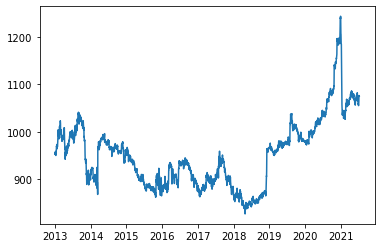

In [21]:
plt.plot(df['2013' :].index, df['2013' :]['AdrBal1in10KCnt'])
plt.show()
plt.close()

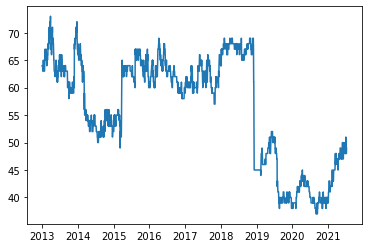

In [17]:
plt.plot(df['2013' :].index, df['2013' :]['AdrBal1in1KCnt'])  # Y axis is too small, mostly exchanges - when whales sell they buy and vv
plt.show()
plt.close()

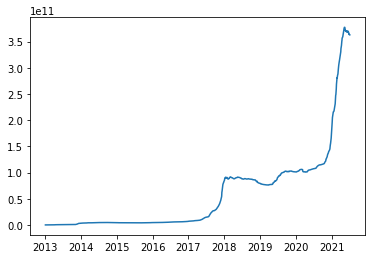

In [22]:
plt.plot(df['2013' :].index, df['2013' :]['CapRealUSD'])
plt.show()
plt.close()